In [3]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process, filter_step_nonlinear, ensrf_steps, kalman_filter_process
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix

# Parameters
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps

J0 = 0
n = 40   # Number of state variables
Q = 0.2 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
H = jnp.eye(n)  # Observation matrix

N = 10 # number of MC samples
n_ensemble = 30
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q

l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [7]:
radius = 10
localization_matrix = generate_localization_matrix(n, radius)
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
inflation = 1
e, c = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)


In [5]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [8]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum

def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0):
   
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, l96_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [9]:
var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0)

Array(103563.84, dtype=float32)

In [13]:
base_m, base_C, base_K  = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)


In [17]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import properscoring

var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.45 # Example starting value for inflation
alpha = 1e-6  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 20  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
localization_matrix = generate_localization_matrix(n, radius) 
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses=[]
inflations = []
true_div = []

n_iters = 500


for i in tqdm(range(n_iters)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    inflations.append(inflation_opt)

    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    true_div.append(total_kl_divergence / num_steps)
    


  0%|          | 0/500 [00:00<?, ?it/s]

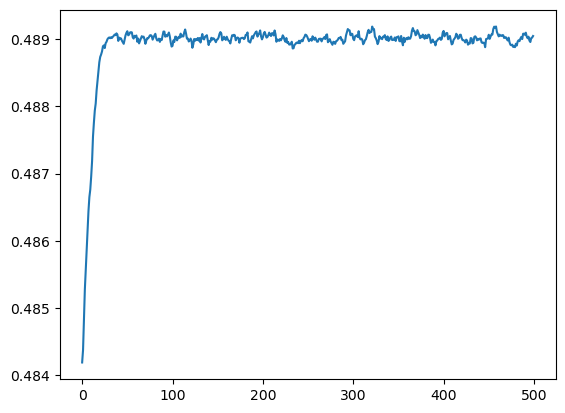

In [18]:
#plt.plot(inflations)
plt.plot(rmses)
#plt.plot(rmses)

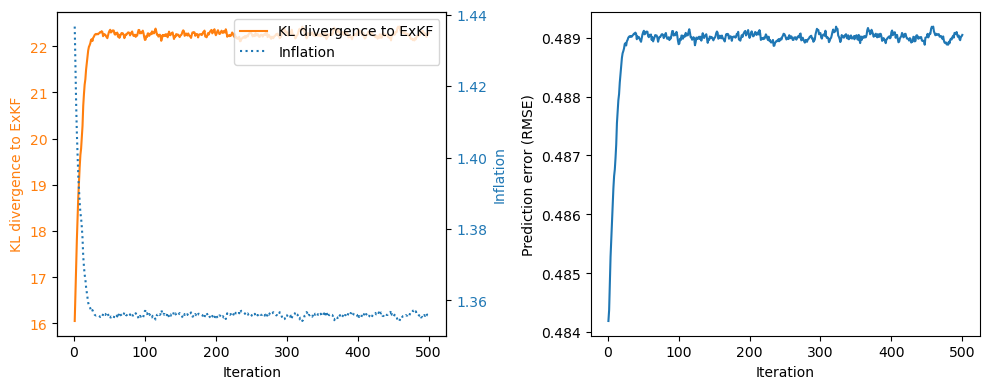

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:orange'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('KL divergence to ExKF', color=color)
ln1 = ax1.plot(range(1, n_iters+1), true_div, label='KL divergence to ExKF', color='tab:orange', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)
ln3 = ax2.plot(range(1, n_iters+1), inflations, label='Inflation', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

ax3.plot(range(1, n_iters+1), rmses)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Prediction error (RMSE)")

plt.tight_layout()
#plt.title('Inflation Parameter and Divergence from True Solution over Iterations')
#plt.show()
plt.savefig("inflation_errors.pdf")

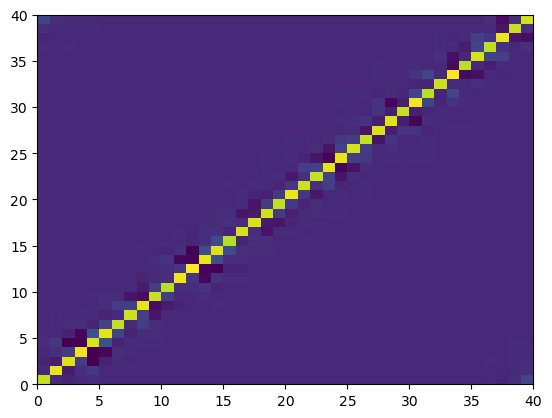

In [20]:
plt.pcolormesh(base_C[-1, :, :])

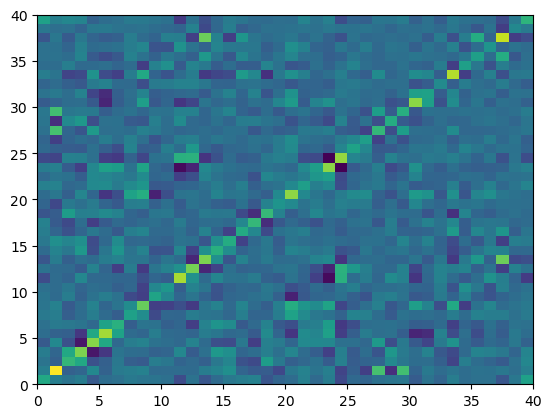

In [82]:
plt.pcolormesh(covariances[-1])

In [88]:
ins = []
cs = []
ds = []

for i in jnp.arange(1.0, 2.0, 0.01):
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, i, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t/num_steps

    c = var_cost(i, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    print(i, c, total_kl_divergence)
    cs.append(c)
    ds.append(total_kl_divergence)
    ins.append(i)

1.0 104666.266 411.19836
1.01 100496.99 394.5053
1.02 95442.38 374.26587
1.03 88935.516 348.2102
1.04 80638.44 314.98398
1.05 71267.41 277.44864
1.06 62313.438 241.56467
1.0699999 54353.0 209.63753
1.0799999 47277.293 181.23422
1.0899999 40926.805 155.71083
1.0999999 35803.723 135.04678
1.1099999 32213.67 120.44476
1.1199999 29509.238 109.30671
1.1299999 27307.348 100.08535
1.1399999 25563.078 92.615814
1.1499999 24092.871 86.19001
1.1599998 22898.652 80.842834
1.1699998 21853.215 76.0479
1.1799998 20980.988 71.91513
1.1899998 20288.305 68.50444
1.1999998 19665.006 65.34691
1.2099998 19114.541 62.426975
1.2199998 18649.21 59.820274
1.2299998 18266.91 57.550533
1.2399998 17959.62 55.62536
1.2499998 17700.572 53.85644
1.2599998 17468.734 52.18306
1.2699997 17275.709 50.666397
1.2799997 17120.65 49.283714
1.2899997 16992.264 48.07934
1.2999997 16887.441 46.804146
1.3099997 16814.225 45.678284
1.3199997 16748.787 44.655117
1.3299997 16695.447 43.591984
1.3399997 16675.705 42.879433
1.34999

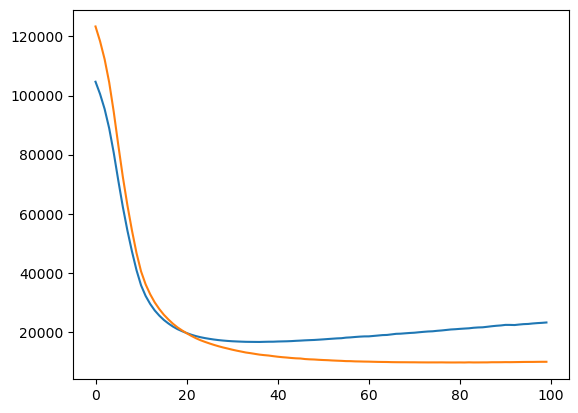

In [94]:
plt.plot(cs)
plt.plot(jnp.array(ds)*300)

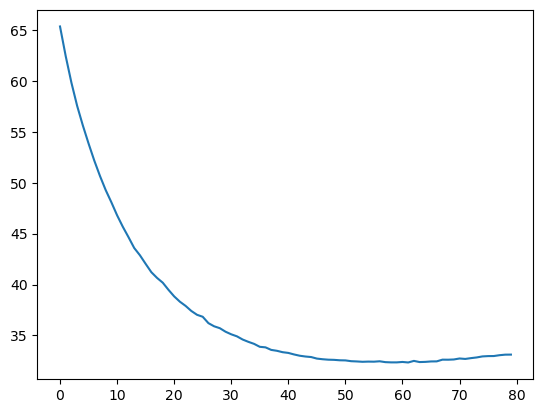

In [96]:
plt.plot(ds[20:])